In [2]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
import pyforest 

pd.set_option("display.max_columns", 100)

<IPython.core.display.Javascript object>

In [3]:
features_df = pd.read_csv("data/training_set_features.csv", index_col='respondent_id')
labels_df = pd.read_csv("data/training_set_labels.csv", index_col='respondent_id')

print(features_df.shape)
# print(features_df.head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(26707, 35)


In [4]:
print(labels_df.shape)

(26707, 2)


In [5]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

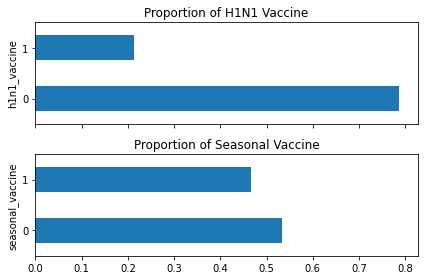

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True)
n_obs = labels_df.shape[0]

(labels_df['h1n1_vaccine'].value_counts().div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_df['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [14]:
pd.crosstab(labels_df['h1n1_vaccine'], 
            labels_df['seasonal_vaccine'],
            margins = True,
            normalize = True
)

<IPython.core.display.Javascript object>

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [15]:
labels_df['h1n1_vaccine'].corr(labels_df['seasonal_vaccine'], method = "pearson")

0.37714265306144473

In [16]:
joined_df = features_df.join(labels_df)
joined_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [22]:
counts = (joined_df[['h1n1_concern', 'h1n1_vaccine']]
          .groupby(['h1n1_concern', 'h1n1_vaccine'])
          .size()
          .unstack('h1n1_vaccine'))
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


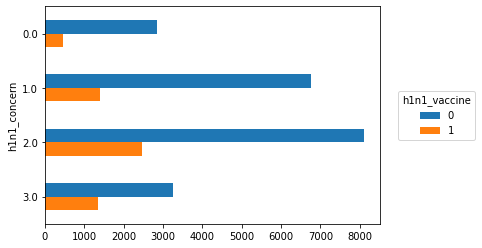

In [23]:
ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right',
    bbox_to_anchor=(1.3,0.5),
    title = 'h1n1_vaccine'
)

In [24]:
h1n1_concern_counts = counts.sum(axis='columns')
h1n1_concern_counts

h1n1_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64

In [25]:
props = counts.div(h1n1_concern_counts, axis='index')
props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


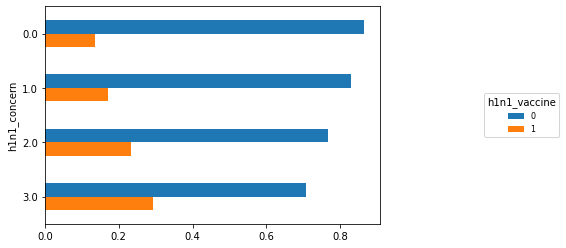

In [26]:
ax = props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', bbox_to_anchor=(1.3, 0.5), fontsize=8, title='h1n1_vaccine')


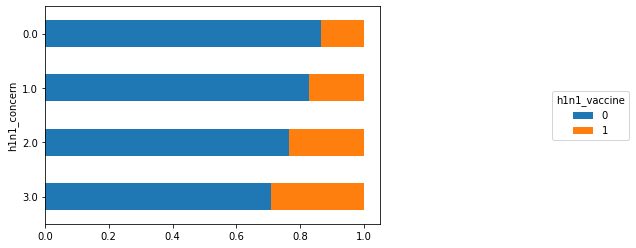

In [34]:
ax = props.plot.barh(stacked = True)
ax.invert_yaxis()
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.5, 0.5),
    title = 'h1n1_vaccine'
)

In [48]:
def vaccination_rate_plot(col, target, data, ax=None):

    counts = (joined_df[[target, col]]
              .groupby([target, col])
              .size()
              .unstack(target)
              )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind='barh', stacked = True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

<IPython.core.display.Javascript object>

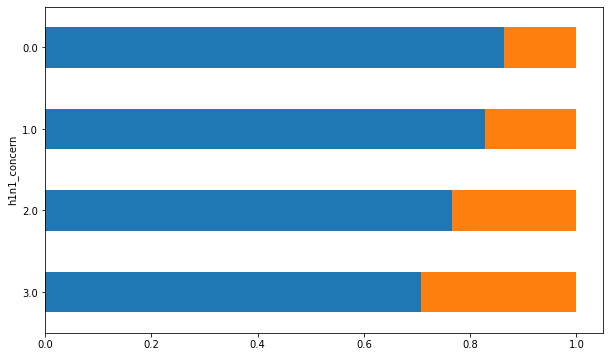

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
vaccination_rate_plot('h1n1_concern', 'h1n1_vaccine', joined_df, ax =ax)

<IPython.core.display.Javascript object>

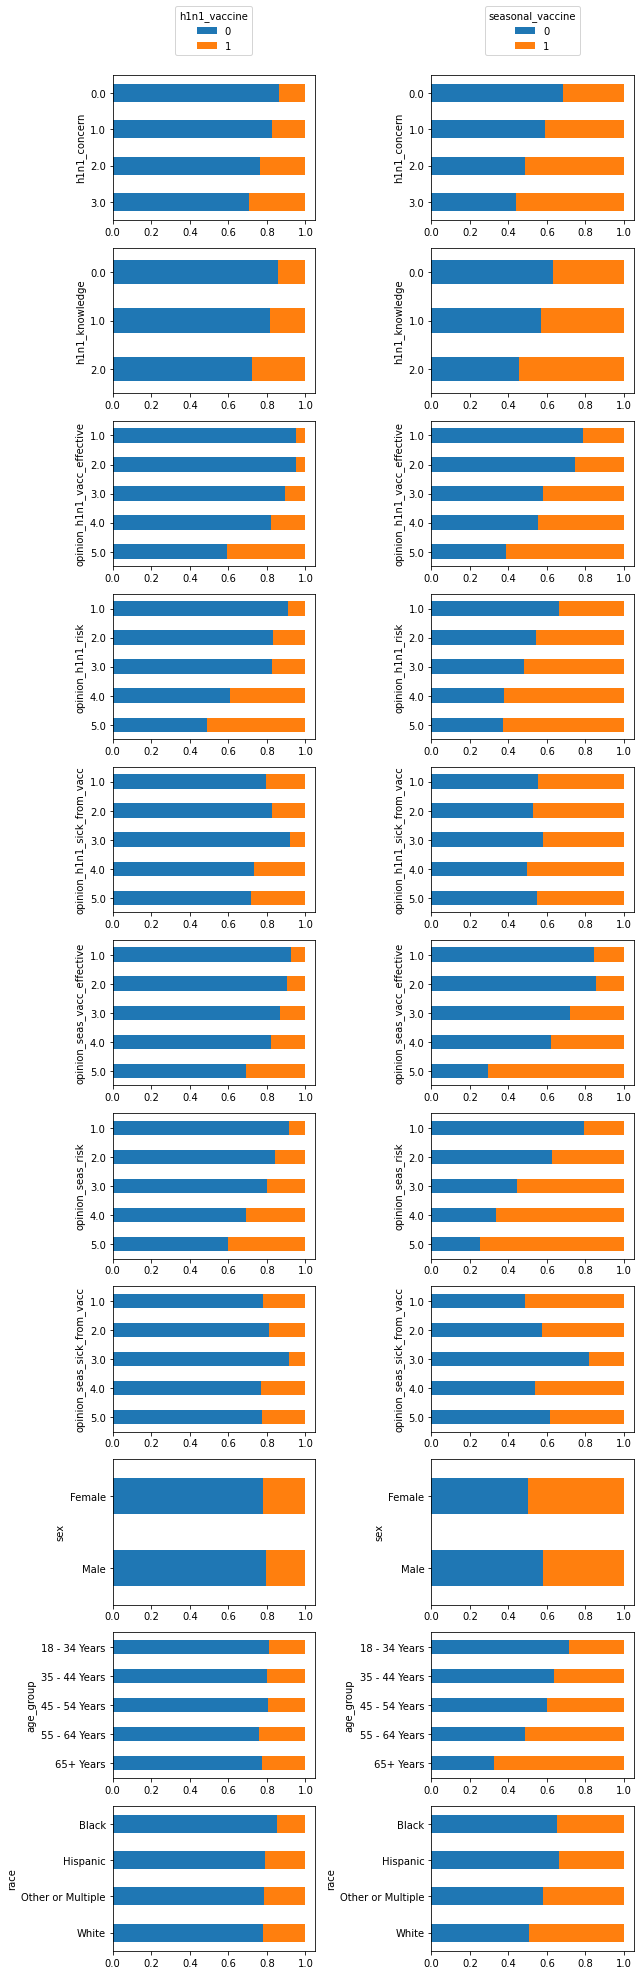

In [63]:
cols_to_plot=[
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig,ax = plt.subplots(len(cols_to_plot), 2, figsize=(9, len(cols_to_plot)*2.5))
# print(ax)

for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(col, 'h1n1_vaccine',joined_df, ax=ax[idx,0])
    vaccination_rate_plot(col, 'seasonal_vaccine', joined_df, ax=ax[idx,1])

ax[0,0].legend(
    loc='lower center', bbox_to_anchor = (0.5, 1.1), title='h1n1_vaccine'
)
ax[0,1].legend(
    loc='lower center', bbox_to_anchor = (0.5, 1.1), title='seasonal_vaccine'
)
fig.tight_layout()

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve

RANDOM_SEED = 6

In [66]:
features_df.dtypes != 'object'

h1n1_concern                    True
h1n1_knowledge                  True
behavioral_antiviral_meds       True
behavioral_avoidance            True
behavioral_face_mask            True
behavioral_wash_hands           True
behavioral_large_gatherings     True
behavioral_outside_home         True
behavioral_touch_face           True
doctor_recc_h1n1                True
doctor_recc_seasonal            True
chronic_med_condition           True
child_under_6_months            True
health_worker                   True
health_insurance                True
opinion_h1n1_vacc_effective     True
opinion_h1n1_risk               True
opinion_h1n1_sick_from_vacc     True
opinion_seas_vacc_effective     True
opinion_seas_risk               True
opinion_seas_sick_from_vacc     True
age_group                      False
education                      False
race                           False
sex                            False
income_poverty                 False
marital_status                 False
r

In [80]:
numeric_cols = features_df.columns[features_df.dtypes != 'object'].values
numeric_cols

array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavioral_outside_home', 'behavioral_touch_face',
       'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'], dtype=object)

In [81]:
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_preprocessing_steps, numeric_cols)
    ], 
    remainder='drop'
)

In [82]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='l2', C=1)
)

In [83]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimators)
])

In [84]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       '...
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'househo

In [92]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)
len(X_train), len(X_eval)

(17893, 8814)

In [89]:
full_pipeline.fit(X_train, y_train)

preds = full_pipeline.predict_proba(X_eval)
preds

[array([[0.70898963, 0.29101037],
        [0.9022304 , 0.0977696 ],
        [0.84459811, 0.15540189],
        ...,
        [0.92338263, 0.07661737],
        [0.89632521, 0.10367479],
        [0.92787943, 0.07212057]]),
 array([[0.52721977, 0.47278023],
        [0.61838467, 0.38161533],
        [0.37024394, 0.62975606],
        ...,
        [0.85936904, 0.14063096],
        [0.77843342, 0.22156658],
        [0.15115096, 0.84884904]])]

In [90]:
print('test_probas[0].shape', preds[0].shape)
print('test_probas[1].shape', preds[1].shape)

test_probas[0].shape (8814, 2)
test_probas[1].shape (8814, 2)


In [91]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine': preds[1][:,1],
    },
    index = y_eval.index
)
print('y_preds.shape', y_preds.shape)
y_preds.head()

<IPython.core.display.Javascript object>

y_preds.shape (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.291010,0.472780
16516,0.097770,0.381615
3106,0.155402,0.629756
16981,0.661791,0.857876
19111,0.284478,0.776927


In [96]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr,tpr)
    ax.plot([0,1],[0,1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

<IPython.core.display.Javascript object>

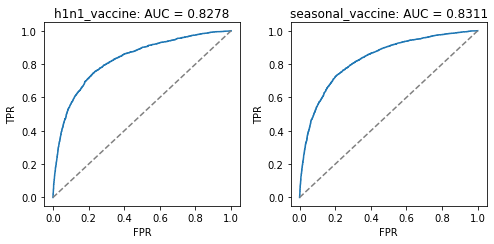

In [97]:
fig, ax = plt.subplots(1,2,figsize=(7,3.5))

plot_roc(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'],
         'h1n1_vaccine', ax = ax[0])

plot_roc(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'],
         'seasonal_vaccine', ax = ax[1])

fig.tight_layout()

In [110]:
print(roc_auc_score(y_eval, y_preds))

0.8294712007285718


In [111]:
full_pipeline.fit(features_df, labels_df)
None

In [112]:
test_features_df = pd.read_csv("data/test_set_features.csv", index_col='respondent_id')

<IPython.core.display.Javascript object>

In [113]:
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

[array([[0.87280333, 0.12719667],
        [0.94475602, 0.05524398],
        [0.62906951, 0.37093049],
        ...,
        [0.80411015, 0.19588985],
        [0.9492446 , 0.0507554 ],
        [0.38421362, 0.61578638]]),
 array([[0.57359831, 0.42640169],
        [0.92876678, 0.07123322],
        [0.3626162 , 0.6373838 ],
        ...,
        [0.59872448, 0.40127552],
        [0.68003071, 0.31996929],
        [0.35787941, 0.64212059]])]

In [118]:
submission_df = pd.read_csv("data/submission_format.csv", index_col='respondent_id')
submission_df.head(10)

<IPython.core.display.Javascript object>

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7
26712,0.5,0.7
26713,0.5,0.7
26714,0.5,0.7
26715,0.5,0.7


In [116]:
np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)

<IPython.core.display.Javascript object>

In [117]:
submission_df['h1n1_vaccine'] = test_probas[0][:,1]
submission_df['seasonal_vaccine'] = test_probas[1][:,1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.127197,0.426402
26708,0.055244,0.071233
26709,0.370930,0.637384
26710,0.464351,0.803446
26711,0.286673,0.634903


In [119]:
submission_df.to_csv('my_submission.csv', index=True)

In [120]:
!head my_submission.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7
26712,0.5,0.7
26713,0.5,0.7
26714,0.5,0.7
26715,0.5,0.7


In [ ]:
# do one hot encoding and use categorical featires as well, using same model
# and then change model 